In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [18]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [19]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    #df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')


In [21]:
len(df_train), len(df_val)

(73908, 61921)

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [23]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206462274

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


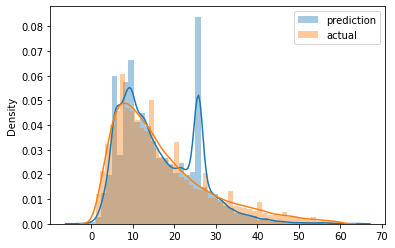

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [27]:
with open('models/lin_reg.bin','wb') as f_out:
   pickle.dump((dv,lr),f_out)

In [28]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

In [29]:
#Add track of experiments with MLflow

with mlflow.start_run():

    mlflow.set_tag("developer", "maria")

    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    #lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [30]:
import xgboost as xgb

In [31]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [33]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[19:09:52] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.18516                          
[1]	validation-rmse:17.42788                          
[2]	validation-rmse:15.89305                          
[3]	validation-rmse:14.55548                          
[4]	validation-rmse:13.39635                          
[5]	validation-rmse:12.39148                          
[6]	validation-rmse:11.52634                          
[7]	validation-rmse:10.78217                          
[8]	validation-rmse:10.14659                          
[9]	validation-rmse:9.60323                           
[10]	validation-rmse:9.14235                          
[11]	validation-rmse:8.75159                          
[12]	validation-rmse:8.42245                          
[13]	validation-rmse:8.14508                          
[14]	validation-rmse:7.91160                          
[15]	validation-rmse:7.71530                          
[

In [18]:
mlflow.xgboost.autolog(disable=False)

In [21]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[11:40:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	valid

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

/Users/cristian.martinez/miniconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
